In [1]:
#trial periodogram

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

C:\Users\muskan\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import h5py

filename = "physio.h5"



#h5.head()

In [4]:
label_file = 'REFERENCE-v3.csv'
df = pd.read_csv(label_file, header = None, names = ['name', 'label'])
df_stat = df.groupby('label').agg('count').reset_index()
df_stat.columns = ['label', 'recordings']
df_stat = df_stat.assign(percent = (100 * np.around(df_stat.recordings/df.shape[0], 2)).astype(np.int))
print(df_stat)
df_set = list(df.label.unique())

  label  recordings  percent
0     A         758        9
1     N        5076       60
2     O        2415       28
3     ~         279        3


C:\Users\muskan\AppData\Local\Temp/ipykernel_6872/2585866670.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_stat = df_stat.assign(percent = (100 * np.around(df_stat.recordings/df.shape[0], 2)).astype(np.int))


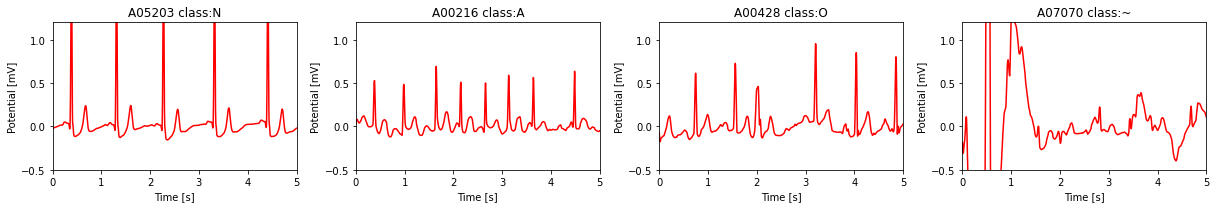

In [5]:
from physionet_processing import fetch_h5data
np.random.seed(148)

# Open large hdf5 file (download https://s3.us-east-2.amazonaws.com/cscie89/physio.h5)
h5file =  h5py.File(filename, 'r')

# Get a list of dataset names 
dataset_list = list(h5file.keys())

def get_sample():
    # Pick one ECG randomly from each class 
    fid_list = [np.random.choice(df[df.label == label].name.values, 1)[0] for label in df_set]
    return fid_list

name_list = get_sample()
slen = 1500
idx_list = [dataset_list.index(name) for name in name_list]
data = fetch_h5data(h5file, idx_list, sequence_length = slen)
time = np.arange(0, slen)/300

fig, ax = plt.subplots(1, len(idx_list), figsize = (17, 3))

for i, ax1 in enumerate(ax):
    
    ax1.plot(time, data[i], color = 'r')
    ax1.set(xlim = [0, 5], xticks = np.arange(0, 5.5, 1),
            ylim = [-0.5, 1.2], yticks = np.arange(-0.5, 1.2, 0.5),
            xlabel = 'Time [s]', ylabel = 'Potential [mV]')
    ax1.set_title(name_list[i] + ' class:' + df_set[i])


plt.tight_layout()
plt.show()    
fig.savefig('physionet_classes.png', bbox_inches = 'tight', dpi = 150)

Unique sampling rates in dataset: [300.0]
Unique gain settings in dataset: [1000.0]
Unique baseline settings: [0.0]
Sequence lengths [min, max]: [2714, 18286]
Recording times in seconds [min, max]: [9.047, 60.953]


C:\Users\muskan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


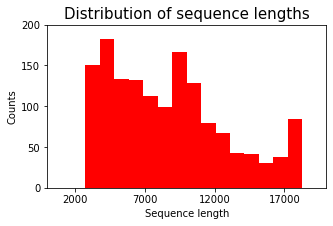

In [6]:
#

from physionet_processing import special_parameters

sequence_lengths, sampling_rates, recording_times, baselines, gains = special_parameters(h5file)
sequence_length_min, sequence_length_max = np.min(sequence_lengths), np.max(sequence_lengths)
recording_time_min, recording_time_max = np.min(recording_times), np.max(recording_times)

print('Unique sampling rates in dataset:', sampling_rates)
print('Unique gain settings in dataset:', gains)
print('Unique baseline settings:', baselines)
print('Sequence lengths [min, max]:', [sequence_length_min, sequence_length_max])
print('Recording times in seconds [min, max]: [%.3f, %.3f]' %(recording_time_min, recording_time_max))

# Plot a histogram of sequence lengths
fig = plt.figure(figsize = (5, 3))
f = sns.distplot(list(sequence_lengths), norm_hist = False, kde = False, color = 'red', hist_kws=dict(alpha=1))
f.set(xlabel = 'Sequence length', xlim = [0, 20000], xticks = np.arange(2000, 20000, 5000))
f.set(ylabel = 'Counts', ylim = [0, 200], yticks = np.arange(0, 250, 50))
plt.title('Distribution of sequence lengths', fontsize=15)
plt.show()
fig.savefig('physionet_sequenceLenHist.png', bbox_inches = 'tight', dpi = 150)

# Based on this, we can set some parameters that we will use in the future
fs = sampling_rates[0] # universal sampling rate
sequence_length = sequence_length_max # will use the maximum sequence length


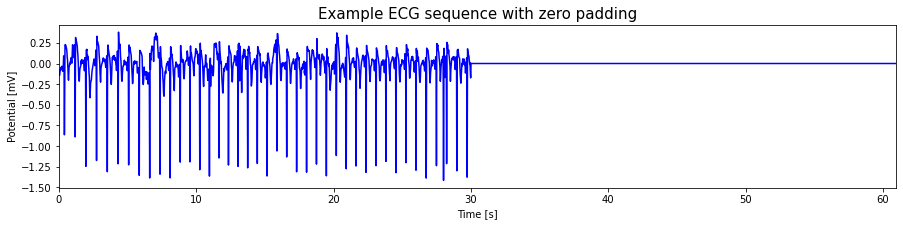

In [7]:
#1. Zero padding to extend sequences

from physionet_processing import extend_ts

ts = h5file[dataset_list[15]]['ecgdata'][:, 0] # Fetch one time series from the hdf5 file
#ts = h5file[list(h5file.keys())[20]]['ecgdata']
ts_extended = extend_ts(ts, length = sequence_length_max) # Extend it to the maximum length
time = np.arange(0, len(ts_extended))/fs

# Plot the the extended time series
fig, ax1 = plt.subplots(figsize = (15, 3))
ax1.plot(time, ts_extended, 'b')
ax1.set(xlabel = 'Time [s]', xlim = [0, time[-1]], xticks = np.arange(0, time[-1]+5, 10))
ax1.set(ylabel = 'Potential [mV]')
plt.title('Example ECG sequence with zero padding', fontsize = 15)
fig.savefig('physionet_ECG_padding.png', bbox_inches = 'tight', dpi = 150)
plt.show()

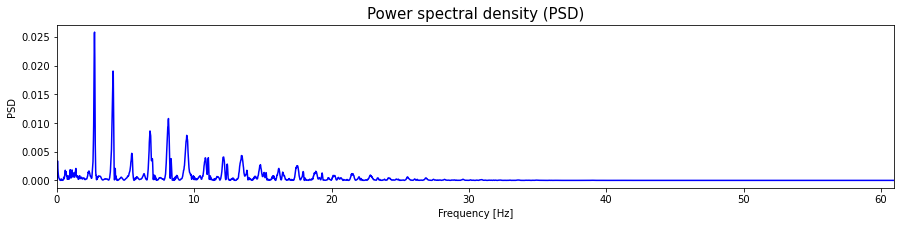

In [8]:
#2. Time series conversion into spectrograms

from scipy import signal
f1, PSD = signal.periodogram(ts_extended, fs, 'flattop', scaling = 'density')
fig, ax1 = plt.subplots(figsize = (15, 3))
ax1.plot(f1, PSD, 'b')
ax1.set(xlabel = 'Frequency [Hz]', xlim = [0, time[-1]], xticks = np.arange(0, time[-1]+5, 10))
ax1.set(ylabel = 'PSD')
plt.title('Power spectral density (PSD)', fontsize = 15)
fig.savefig('physionet_ECG_PSD.png', bbox_inches = 'tight', dpi = 150)
plt.show()

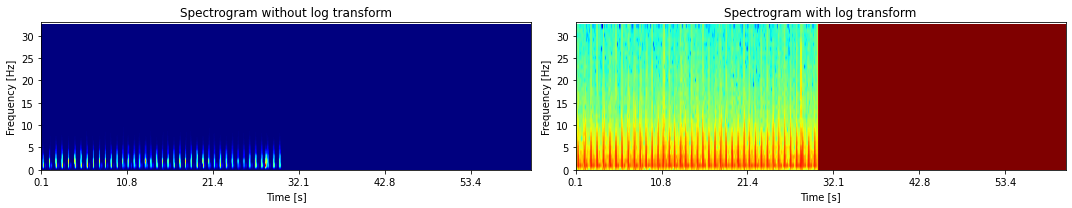

In [9]:
from physionet_processing import spectrogram

# Convert ECG into spectrograms without and with log transform
Sx = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False)[2]
Sx_log = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = True)[2]

# Get the frequency and time axes
f, t, _ = spectrogram(np.expand_dims(ts_extended, axis = 0), log_spectrogram = False) 

# Plot the spectrograms as images
im_list = [Sx[0], Sx_log[0]]
im_title = ['Spectrogram without log transform', 'Spectrogram with log transform']
fig, ax_list = plt.subplots(1, 2, figsize = (15, 3))

for i, ax in enumerate(ax_list):
    
    ax.imshow(np.transpose(im_list[i]), aspect = 'auto', cmap = 'jet')
    ax.grid(False)
    ax.invert_yaxis()
    ax.set_title(im_title[i], fontsize = 12)
    ax.set(ylim = [0, im_list[i].shape[1]], yticks = np.arange(0, im_list[i].shape[1] + 1, 5))
    ax.set(xlabel = 'Time [s]', ylabel = 'Frequency [Hz]')
    
    # Replace axis labels with time from t array
    xticks_array = np.arange(0, im_list[i].shape[0] + 1, 100)
    ax.set(xlim = [0, im_list[i].shape[0]], xticks = xticks_array)
    labels_new = [str(np.around(t[label], decimals = 1)) for label in xticks_array]
    ax.set_xticklabels(labels_new)
    ax.tick_params(axis = 'x',
                   which = 'both',
                   bottom = 'off')
    
    ax.tick_params(axis = 'y',
                   which = 'both',
                   left = 'off')

plt.tight_layout()
plt.show()
fig.savefig('physionet_ECG_spectrogram.png', bbox_inches = 'tight', dpi = 150)

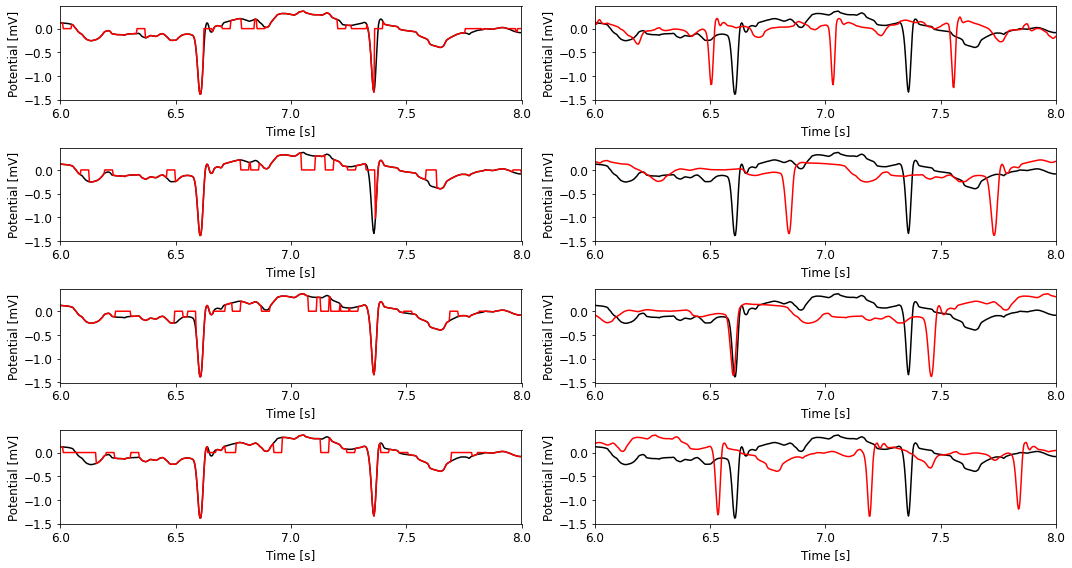

In [10]:
#3. Data augmentation to reduce overfitting

from physionet_processing import zero_filter, random_resample

data_zero = [] # collect the zero burst data here
data_resampled = [] # list for resampled data
runs = 4

for i in range(runs):
    data_zero.append(zero_filter(np.expand_dims(ts_extended, axis = 0), threshold = 2, depth = 10)[0])
    data_resampled.append(random_resample(np.expand_dims(ts_extended, axis = 0))[0])

# Plot the result
fig, axarr = plt.subplots(runs, 2, figsize = (15, 8))
x_lim = [6, 8] # zoom in on x axis
x_ticks = np.arange(x_lim[0], x_lim[1] + 0.5, 0.5) # ticks
x_label = 'Time [s]'
y_label = 'Potential [mV]'

for row in range(runs):
    
    # Plot the dropout burst data
    ax = axarr[row, 0]
    ax.plot(time, ts_extended, 'k')
    ax.plot(time, data_zero[row], 'r')
    ax.set(xlim = x_lim, xticks = x_ticks)
    ax.set(xlabel = x_label, ylabel = y_label)
    
    # Plot the resampling data
    ax = axarr[row, 1]
    ax.plot(time, ts_extended, 'k')
    ax.plot(time, data_resampled[row], 'r')
    ax.set(xlim = x_lim, xticks = x_ticks)
    ax.set(xlabel = x_label, ylabel = y_label)
    
for ax in np.ndarray.flatten(axarr):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

plt.tight_layout()
#plt.suptitle('Data augmentation: dropout bursts and random resampling', fontsize = 15)
plt.show()
fig.savefig('physionet_augmentation.png', bbox_inches = 'tight', dpi = 150)

In [11]:
# The initialization function of the generator class defines the parameters 
# that are needed for ECG processing
'Generates data for Keras'
def __init__(self, h5file, list_IDs, labels, batch_size = 32, dim = (178, 33), 
             nperseg = 64, noverlap = 32,
             n_channels=1, sequence_length = 5736,
             n_classes = 4, shuffle = True, augment = False):
    
    'Initialization'
    self.h5file = h5file
    self.list_IDs = list_IDs
    self.labels = labels
    self.batch_size = batch_size
    self.dim = dim
    self.nperseg = nperseg
    self.noverlap = noverlap
    self.n_channels = n_channels
    self.sequence_length = sequence_length
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.augment = augment
    self.on_epoch_end()

In [12]:
def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype = float)
        y = np.empty((self.batch_size), dtype = int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            data = extend_ts(self.h5file[ID]['ecgdata'][:, 0], self.sequence_length)
            data = np.reshape(data, (1, len(data)))
        
            if self.augment:
            
                # dropout bursts
                data = zero_filter(data, threshold = 2, depth = 10)
            
                # random resampling
                data = random_resample(data)
            
            # Generate spectrogram
            data_spectrogram = spectrogram(data, nperseg = self.nperseg, noverlap = self.noverlap)[2]
            
            # Normalize spectrogram
            #data_transformed = norm_float(data_spectrogram, self.data_mean, self.data_std)
            data_norm = (data_spectrogram - np.mean(data_spectrogram))/np.std(data_spectrogram)
        
            X[i,] = np.expand_dims(data_norm, axis = 3)
        
            # Assuming that the dataset names are unique (only 1 per label)
            y[i] = self.labels[ID]

        return X, keras.utils.np_utils.to_categorical(y, num_classes=self.n_classes)
    
    

In [13]:
from sklearn.preprocessing import LabelEncoder

# Load the labels:
label_df = pd.read_csv(label_file, header = None, names = ['name', 'label'])

# Hot-encode the labels
label_set = list(sorted(label_df.label.unique()))
encoder = LabelEncoder().fit(label_set)
label_set_codings = encoder.transform(label_set)
label_df = label_df.assign(encoded = encoder.transform(label_df.label))

print('Unique labels:', encoder.inverse_transform(label_set_codings))
print('Unique codings:', label_set_codings)
print('Dataset labels:\n', label_df.iloc[100:110,])

Unique labels: ['A' 'N' 'O' '~']
Unique codings: [0 1 2 3]
Dataset labels:
        name label  encoded
100  A00101     A        0
101  A00102     A        0
102  A00103     O        2
103  A00104     N        1
104  A00105     N        1
105  A00106     ~        3
106  A00107     A        0
107  A00108     O        2
108  A00109     N        1
109  A00110     O        2


In [14]:
from sklearn.model_selection import train_test_split

# Split the IDs in training and validation set
test_split = 0.33
idx = np.arange(label_df.shape[0])
id_train, id_val, _, _ = train_test_split(idx, idx, 
                                         test_size = test_split,
                                         shuffle = True,
                                         random_state = 123)

# Store the ids and labels in dictionaries
partition = {'train': list(label_df.iloc[id_train,].name), 
             'validation': list(label_df.iloc[id_val,].name)}

labels = dict(zip(label_df.name, label_df.encoded))

In [15]:
# Parameters needed for the DataGenerator class
# Maximum sequence length
max_length = sequence_length

# Output dimensions
sequence_length = sequence_length_max # Use the maximum sequence length in the data set
spectrogram_nperseg = 64 # Spectrogram hanning window width
spectrogram_noverlap = 32 # Spectrogram hanning window overlap
n_classes = len(label_df.label.unique()) # Number of classes
batch_size = 32

# Use one spectrogram to detemine the image dimensions
Sx_log = spectrogram(np.expand_dims(ts_extended, axis = 0),
                     nperseg = spectrogram_nperseg,
                     noverlap = spectrogram_noverlap,
                     log_spectrogram = True)[2]
dim = Sx_log[0].shape

In [16]:
from physionet_generator import DataGenerator

params = {'batch_size': batch_size,
          'dim': dim,
          'nperseg': spectrogram_nperseg,
          'noverlap': spectrogram_noverlap,
          'n_channels': 1,
          'sequence_length': sequence_length,
          'n_classes': n_classes,
          'shuffle': True}

train_generator = DataGenerator(h5file, partition['train'], labels, augment = True, **params)
val_generator = DataGenerator(h5file, partition['validation'], labels, augment = False, **params)

for i, batch in enumerate(train_generator):
    if i == 1:
        break

X = batch[0]
y = batch[1]

print('X shape:', X.shape)
print('y shape:', y.shape)
print('X type:', np.dtype(X[0,0,0,0]))

X shape: (32, 570, 33, 1)
y shape: (32, 4)
X type: float64


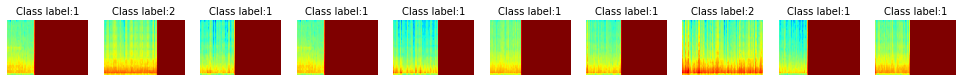

In [17]:
def imshow_batch(X, y, batch_idx):
    
    batch_labels = ['Class label:' + str(np.argmax(y[idx,])) for idx in batch_idx]

    fig, ax = plt.subplots(1, len(batch_idx), figsize = (17, 1))

    for i, idx in enumerate(batch_idx):
    
        ax[i].imshow(X[idx, :, :, 0].transpose(), cmap = 'jet', aspect = 'auto')
        ax[i].grid(False)
        ax[i].axis('off')
        ax[i].invert_yaxis()
        ax[i].set_title(batch_labels[i], fontsize = 10)
    
    plt.show()
        
    return fig

batch_idx = np.random.randint(0, batch_size, size = 10) 
fig = imshow_batch(X, y, batch_idx)
fig.savefig('physionet_Batch.png', bbox_inches = 'tight', dpi = 150)
plt.show()

In [18]:
#Define the Keras model

# Convolutional blocks
def conv2d_block(model, depth, layer_filters, filters_growth, 
                 strides_start, strides_end, input_shape, first_layer = False):
    
    ''' Convolutional block. 
    depth: number of convolutional layers in the block (4)
    filters: 2D kernel size (32)
    filters_growth: kernel size increase at the end of block (32)
    first_layer: provide input_shape for first layer'''
    
    # Fixed parameters for convolution
    conv_parms = {'kernel_size': (3, 3),
                  'padding': 'same',
                  'dilation_rate': (1, 1),
                  'activation': None,
                  'data_format': 'channels_last',
                  'kernel_initializer': 'glorot_normal'}

    for l in range(depth):

        if first_layer:
            
            # First layer needs an input_shape 
            model.add(layers.Conv2D(filters = layer_filters,
                                    strides = strides_start,
                                    input_shape = input_shape, **conv_parms))
            first_layer = False
        
        else:
            # All other layers will not need an input_shape parameter
            if l == depth - 1:
                # Last layer in each block is different: adding filters and using stride 2
                layer_filters += filters_growth
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_end, **conv_parms))
            else:
                model.add(layers.Conv2D(filters = layer_filters,
                                        strides = strides_start, **conv_parms))
        
        # Continue with batch normalization and activation for all layers in the block
        model.add(layers.BatchNormalization(center = True, scale = True))
        model.add(layers.Activation('relu'))
    
    return model

In [19]:
# Input shape
n_channels = 1 # Number of color channgels
input_shape = (*dim, n_channels) # input shape for first layer

# Hyperparameters
filters_start = 32 # Number of convolutional filters
layer_filters = filters_start # Start with these filters
filters_growth = 32 # Filter increase after each convBlock
strides_start = (1, 1) # Strides at the beginning of each convBlock
strides_end = (2, 2) # Strides at the end of each convBlock
depth = 2 # Number of convolutional layers in each convBlock
n_blocks = 6 # Number of ConBlocks

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

model = Sequential()

for block in range(n_blocks):

    # Provide input only for the first layer
    if block == 0:
        provide_input = True
    else:
        provide_input = False
    
    model = conv2d_block(model, depth,
                         layer_filters,
                         filters_growth,
                         strides_start, strides_end,
                         input_shape,
                         first_layer = provide_input)
    
    # Increase the number of filters after each block
    layer_filters += filters_growth

In [21]:
#Feature aggregation over time
# Define temporal feature avaraging layer
import tensorflow.keras.backend as K
def MeanOverTime():
    lam_layer = layers.Lambda(lambda x: K.mean(x, axis=1), output_shape=lambda s: (1, s[2]))
    return lam_layer

# Reshape to (batch, time steps, filters)
model.add(layers.Reshape((-1, 224)))
model.add(layers.Masking(mask_value = 0.0))
model.add(MeanOverTime())

# And a fully connected layer for the output
model.add(layers.Dense(4, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 570, 33, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 570, 33, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 570, 33, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 285, 17, 64)       18496     
                                                                 
 batch_normalization_1 (Batc  (None, 285, 17, 64)      256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 285, 17, 64)       0

In [22]:
# pip install pydot

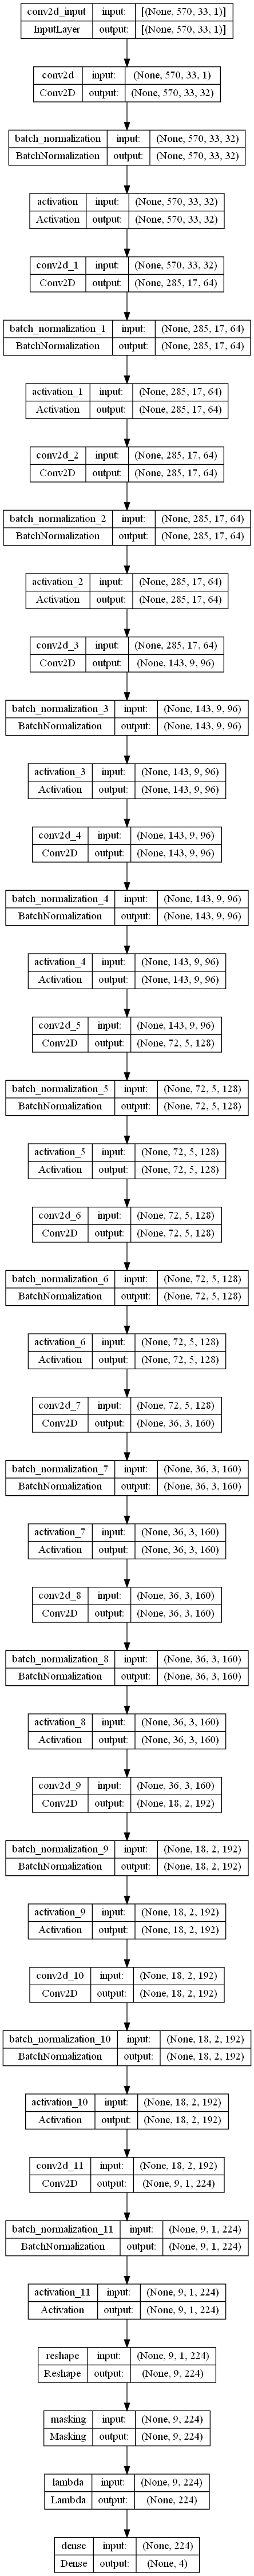

In [23]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'model.png', show_shapes=True)

In [24]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [25]:
import datetime
from tensorflow import keras
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='Models_TF/model_{epoch}',
        save_freq='epoch'),
    tensorboard_callback
]

In [27]:
df_stat

,label,recordings,percent
0,A,758,9
1,N,5076,60
2,O,2415,28
3,~,279,3


In [28]:
total = df_stat['recordings'].sum()

In [29]:
df_stat['weight'] = total/df_stat['recordings']

In [30]:
df_stat

,label,recordings,percent,weight
0,A,758,9,11.250660
1,N,5076,60,1.680063
2,O,2415,28,3.531263
3,~,279,3,30.566308


In [31]:
df_stat['weight'][1]

1.6800630417651694

In [32]:
df_set

['N', 'A', 'O', '~']

In [33]:
class_weight = {0: df_stat['weight'][1],
                1: df_stat['weight'][0],
                2: df_stat['weight'][2],
                3: df_stat['weight'][3]}

In [34]:
class_weight

{0: 1.6800630417651694,
 1: 11.25065963060686,
 2: 3.531262939958592,
 3: 30.566308243727597}

In [35]:
# Compile the model and run a batch through the network
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

In [ ]:


model.fit(train_generator,
                              steps_per_epoch = 50,
                              epochs = 50,
                              validation_data = val_generator,
                              validation_steps = 50,
          callbacks=[callbacks], class_weight = class_weight)

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 7.1945 - acc: 0.5713

In [ ]:
%tensorboard --logdir logs/fit